# Access this notebook on kaggle at <a href='https://www.kaggle.com/code/ahmedheshamsbe/hr-9classes-diceloss'>this link</a>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from collections import namedtuple
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to 

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )
#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground' 
          , 8       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),]

In [4]:
mapping_20 = { 
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 8,
        9: 1,
        10: 1,
        11: 2,
        12: 2,
        13: 2,
        14: 2,
        15: 2,
        16: 2,
        17: 3,
        18: 3,
        19: 3,
        20: 3,        
        21: 4,
        22: 4,
        23: 5,
        24: 6,
        25: 6,
        26: 7,
        27: 7,
        28: 7,
        29: 7,
        30: 7,
        31: 7,
        32: 7,
        33: 7,
        34: 7
    }

In [5]:
width, height = 128, 128
IMAGE_SIZE = [width, height]
classes = 9
batch_size = 16
id2color = { label.id : np.asarray(label.color) for label in labels }

In [6]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 # crop image section and reformat as normalized np array
    mask = np.array(mask) # crop mask section and reformat as np array
    
    return image, mask
def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
    
    return closest_category
def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask

In [7]:
train_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
val_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'

# Store the images, the masks, and the encoded masks
train_images = [] 
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []

In [8]:

for train_file in tqdm(os.listdir(train_filepath), desc = 'Building Training Dataset: '):
    image, mask = image_mask_split(train_filepath + train_file, IMAGE_SIZE)
    train_images.append(image)
    train_masks.append(mask)
    train_masks_enc.append(encode_labels(find_closest_labels_vectorized(mask, id2color)))
    
for val_file in tqdm(os.listdir(val_filepath), desc = 'Building Validation Dataset: '):
    image, mask = image_mask_split(val_filepath + val_file, IMAGE_SIZE)
    val_images.append(image)
    val_masks.append(mask)
    val_masks_enc.append(encode_labels(find_closest_labels_vectorized(mask, id2color)))

Building Validation Dataset: 100%|██████████| 500/500 [00:29<00:00, 16.77it/s]


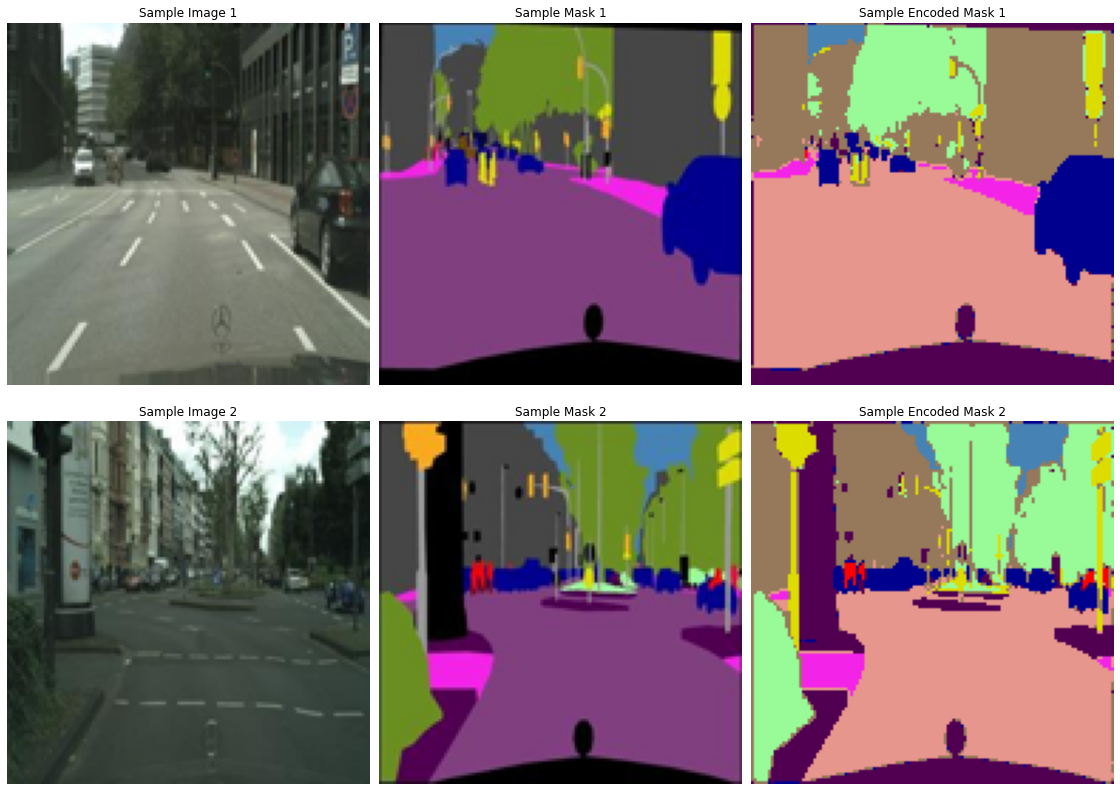

In [9]:
id2color = { label.categoryId : np.asarray(label.color) for label in labels }
plt.figure(figsize=[20, 14])

for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [10]:
np.unique(train_masks_enc[12])

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=object)

In [11]:
del train_masks, val_masks


In [12]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [30]:
def bottle_neck(inputs):
  res = inputs
  x = layers.Conv2D(32,kernel_size=1,padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)

  x2 = layers.Conv2D(32,kernel_size=3,padding='same')(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  x3 = layers.Conv2D(96,kernel_size=1,padding='same')(x2)
  x3 = layers.BatchNormalization()(x3)
  x3 = tf.keras.activations.relu(x3)
  res = layers.Conv2D(96 , kernel_size =1 , padding = 'same')(res)
  output = tf.keras.layers.Add()([x3 , res])

  output = tf.keras.activations.relu(output)
  return output 

def basic_block(inputs,num_channels,stride,padding):
  res = inputs

  x = layers.Conv2D(num_channels,kernel_size=3,strides=stride,padding = padding)(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  
  x2 = layers.Conv2D(num_channels,kernel_size=3,strides=1,padding = padding)(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  return x2

In [31]:
input_shape = keras.Input(shape=(width, height, 3))

x1 = bottle_neck(input_shape)
x1 = bottle_neck(x1)

x21 = basic_block(x1,x1.shape[3],1,'same')
x21 = basic_block(x21,x21.shape[3],1,'same')
print(x21.shape)

x22 = basic_block(x1,x1.shape[3]*2,2,'same')
x22 = basic_block(x22,x22.shape[3],1,'same')
print(x22.shape)


x31_1 = basic_block(x21,x21.shape[3],1,'same')
print(x31_1.shape)

x31_2 = layers.UpSampling2D((2,2))(x22)
x31_2 = layers.Conv2D(x31_1.shape[3], (1,1) , strides =1 , padding = "same")(x31_2)
x31 = tf.keras.layers.Add()([x31_1,x31_2])
print(x31.shape)

x32_1 = basic_block(x21 , x21.shape[3]*2 , 2 , 'same')

x32_2 = basic_block(x22 , x22.shape[3] , 1, 'same')
x32_1= layers.Conv2D(x32_2.shape[3], (1,1) , strides =1 , padding = "same")(x32_1)

x32 =tf.keras.layers.Add()([x32_1,x32_2])

print(x32.shape)

x33_1 = basic_block(x21 , x21.shape[3]*4 , 4 , 'same')
x33_2 = basic_block(x22 , x22.shape[3]*2 , 2 , 'same')

x33 = tf.keras.layers.Add()([x33_1,x33_2])

print(x33.shape)


x31 = basic_block(x31,x31.shape[3],1,'same')
print(x31.shape)
x31 = basic_block(x31,x31.shape[3],1,'same')
print(x31.shape)

x32 = basic_block(x32,x32.shape[3],1,'same')
print(x32.shape)
x32 = basic_block(x32,x32.shape[3],1,'same')
print(x32.shape)

x33 = basic_block(x33,x33.shape[3],1,'same')
print(x33.shape)
x33 = basic_block(x33,x33.shape[3],1,'same')
print(x33.shape)


x41_1 =  basic_block(x31,x31.shape[3],1,'same')
x41_2 =  layers.UpSampling2D((2,2))(x32)
x41_2 = layers.Conv2D(x41_1.shape[3], (1,1) , strides =1 , padding = "same")(x41_2)
x41_3 = layers.UpSampling2D((4,4))(x33)
x41_3= layers.Conv2D(x41_1.shape[3], (1,1) , strides =1 , padding = "same")(x41_3)

output = tf.keras.layers.Add()([x41_1,x41_2 , x41_3])
print(output.shape)


output = layers.Conv2D(classes,1,1,padding='same')(output)

(None, 128, 128, 96)
(None, 64, 64, 192)
(None, 128, 128, 96)
(None, 128, 128, 96)
(None, 64, 64, 192)
(None, 32, 32, 384)
(None, 128, 128, 96)
(None, 128, 128, 96)
(None, 64, 64, 192)
(None, 64, 64, 192)
(None, 32, 32, 384)
(None, 32, 32, 384)
(None, 128, 128, 96)


In [32]:
model = keras.Model(inputs= input_shape,outputs = output,name = "HR-NET")
model.summary()

Model: "HR-NET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 128, 128, 32) 128         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 128, 128, 32) 128         conv2d_90[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_80 (TFOpLambda)      (None, 128, 128, 32) 0           batch_normalization_76[0][0]     
_____________________________________________________________________________________________

In [48]:
import tensorflow.keras.backend as K
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-7, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def dice_coef(self,y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1- tf.divide(nominator, denominator)
        return result

    def call(self,y_true, y_pred, M=9):
        y_true = tf.one_hot(tf.cast(y_true,tf.int32),M)
        dice = 0
        for index in range(M):
            dice += self.dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return dice
    

In [49]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

loss = DiceLoss()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01        
                                    ,decay=0.005),
    loss=loss,
    metrics = ["accuracy", UpdatedMeanIoU(num_classes=classes, name = "mean_iou")])


In [50]:
MODEL_CHECKPOINT_FILEPATH = '/kaggle/working/cityscapes-Hr-net.ckpt'
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_mean_iou',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_miou', 
                               patience = 5,
                               restore_best_weights = True, 
                               min_delta = 0.0001,
                               mode='max',
                               verbose=2,
                               baseline=None)
    
callbacks = [model_checkpoint , early_stopping]

In [51]:
history = model.fit(x = train_images,
                    y = train_masks_enc,
                    batch_size = 16,
                    epochs = 40,
                    validation_data = (val_images, val_masks_enc))

Epoch 1/40
186/186 [==============================] - 175s 917ms/step - loss: 4.7995 - accuracy: 0.5632 - mean_iou: 0.3125 - val_loss: 4.7065 - val_accuracy: 0.5024 - val_mean_iou: 0.2603
Epoch 2/40
186/186 [==============================] - 171s 919ms/step - loss: 4.1016 - accuracy: 0.1900 - mean_iou: 0.1004 - val_loss: 4.8183 - val_accuracy: 0.3365 - val_mean_iou: 0.1531
Epoch 3/40
186/186 [==============================] - 171s 920ms/step - loss: 3.0316 - accuracy: 0.7417 - mean_iou: 0.4376 - val_loss: 3.6346 - val_accuracy: 0.7232 - val_mean_iou: 0.4076
Epoch 4/40
186/186 [==============================] - 171s 921ms/step - loss: 2.5531 - accuracy: 0.8073 - mean_iou: 0.5438 - val_loss: 3.6010 - val_accuracy: 0.7414 - val_mean_iou: 0.4144
Epoch 5/40
186/186 [==============================] - 172s 924ms/step - loss: 2.4161 - accuracy: 0.8162 - mean_iou: 0.5613 - val_loss: 3.4786 - val_accuracy: 0.6883 - val_mean_iou: 0.4211
Epoch 6/40
186/186 [==============================] - 171s 9

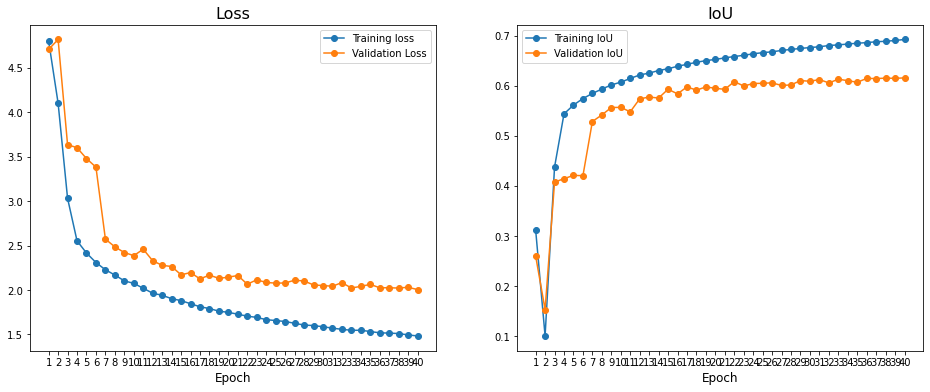

In [54]:
EPOCHS=40
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, EPOCHS + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, EPOCHS + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, EPOCHS + 1), history.history['mean_iou'], marker='o', label='Training IoU')
ax2.plot(range(1, EPOCHS + 1), history.history['val_mean_iou'], marker='o', label='Validation IoU')
ax2.legend()
ax2.set_xticks(range(1, EPOCHS + 1))
ax2.set_title('IoU', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [55]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH) # load the best model weights

val_loss, val_accuracy,val_mIoU = model.evaluate(x = val_images, y = val_masks_enc) # re-evaluate on the validation data

print('The model had an accuracy score of '+str(format(round(100*val_accuracy, 2))) + ' and a mIoU of '+ str(format(round(100*val_mIoU, 2))))

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /kaggle/working/cityscapes-Hr-net.ckpt

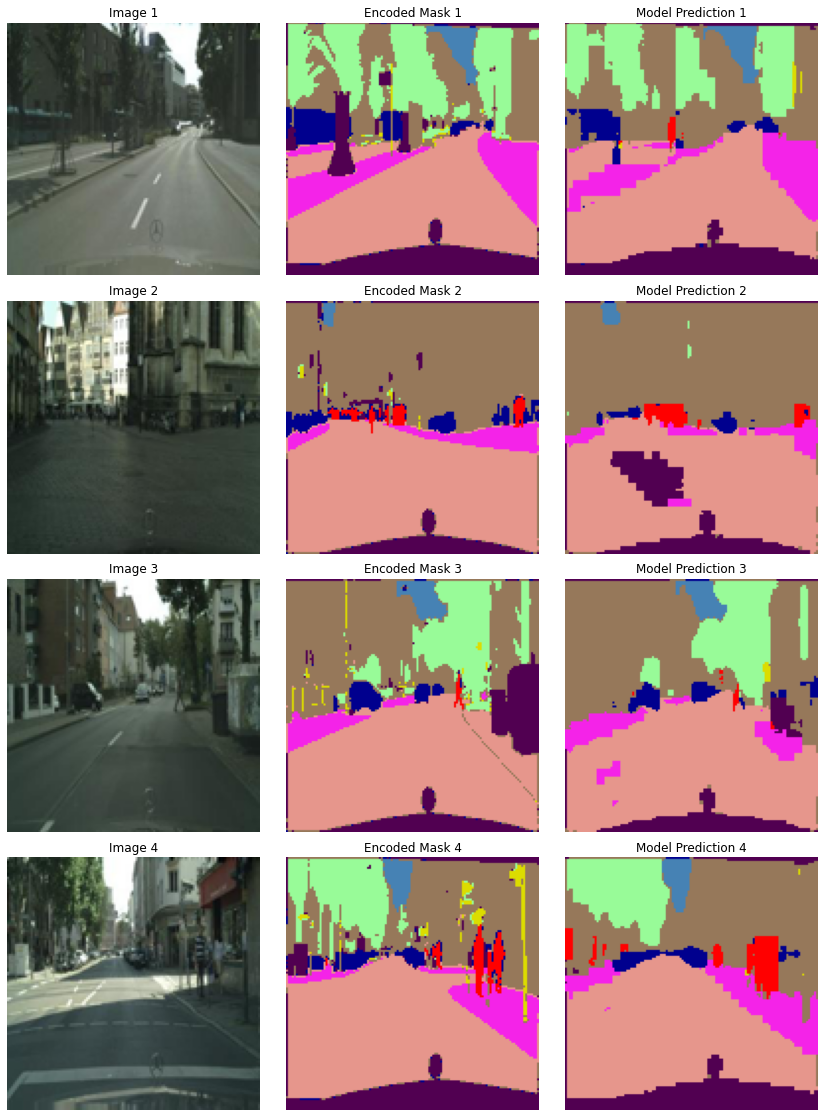

In [56]:
plt.figure(figsize=[15, 20])
IMAGE_SHAPE = IMAGE_SIZE + [3,]

for i in range(4):    
    img = val_images[i]
    enc = val_masks_enc[i]
    
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))
    
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8')
                     
            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')
            
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [ ]:
model.save("9classes_MIOU.h5")